# DATA515 Yelp Reviews

## Visualization Example using MapBox

### Objective:

Yelp search does not allow for simple filtered search by ratings- can we build an intuitive, interactive map that allows users to search for restaurants given a ratings range? 
What other filters can be added?

Further, given Yelp's rich text data, what sort of insights can be gained from their reviews?  

- Can ratings be predicted from review text?
- Can we extract keywords from the reviews?
- How accurate are the restaurant searches? (A search for "tacos" in Seattle returns restaurants that aren't even marginally related to tacos, for example"

The text processing and learning portion of this project has been shelved mostly as a next step project.

### Generating Maps

#### Step 1: Build interactive map using MapBox

In [49]:
#Imports

import os
from pathlib import Path

import pandas as pd
import numpy as np

from mapboxgl.utils import create_color_stops, df_to_geojson
from mapboxgl.viz import CircleViz

import sys
import re

import ipywidgets as widgets

import nltk
import collections

import matplotlib.pyplot as plt

from wordcloud import WordCloud, STOPWORDS

sys.path.append(str(Path(os.getcwd()).parents[0]))

from yelp_reviews import (
    get_viz, 
    get_latest_reviews, 
    read_all_reviews,
    preprocess, 
    get_rare_words
)

import yelp_reviews

In [5]:
#read token for MapBox, API key for Yelp Fusion API

def read_api_key():
    dir_path = str(Path(os.getcwd()).parents[0])
    api_key = Path(os.path.join(dir_path, "yelp_reviews", 
                                "api_key.txt")).read_text()
    return api_key

api_key = read_api_key()
#print(read_api_key())

In [7]:
#read data from prepared .csv file
#The parameters for this search was "Tacos" in "University District, Seattle"


dir_path = str(Path(os.getcwd()).parents[0])
file_path = Path(os.path.join(dir_path, "data", "api_data.csv"))

In [8]:
#prepare mapBox map

viz = get_viz(file_path)

#render map

viz.show()

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


#### Step 2: Add filters based on discrete variables

As we can see from the map above, the Yelp API returned some restaurants that were marginally taco-like, but also some which seemingly had little to do with tacos (Chowders??)

We will now filter the returned dataset by its discrete variables: price (which here is discrete as "$" ratings), category, or transaction type.

In [9]:
#Set API search parameters.
#Example search: Tacos in UDistrict


params = {"term" : "tacos",
          "location" : "University District, Seattle",
          "categories" : "restaurants"}

In [10]:
#Filter map based on price

filter_col = "price"
target = "$$"

viz2 = get_viz(file_path, filter_col = filter_col, target = target)

viz2.show()

In [11]:
#Filter map based on transaction types

filter_col = "transactions"
target_list = ["pickup"]

viz3 = get_viz(file_path, filter_col = filter_col, target = target_list)

viz3.show()

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [14]:
#Filter map based on transaction values

filter_col = "rating"
target_list = ["texmex", "tacos", "mexican"]

viz4 = get_viz(file_path, filter_col = filter_col, target = target_list)

viz4.show()

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


#### Step 3: Add filters based on continuous variables

Finally, we can also add filters based on ratings

In [15]:
#Filter map based on rating

filter_col = "rating"
target = 3

viz5 = get_viz(file_path, filter_col=filter_col, target=target, g_than = True)

viz5.show()

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


### Processing review text data

We wanted to also create visualization based on the review text data.

In [17]:
#Setup- get prepared review text

f1 = Path(os.path.join(dir_path, "data", "reviews.csv"))
f2 = Path(os.path.join(dir_path, "data", "reviewCountOnPage.csv"))

reviews = get_latest_reviews(f1, f2)

In [19]:
#Preprocessing- remove stopwords, rare words

extra_stopwords = set(["wa", "apos", "food", "place"])
SW = set(nltk.corpus.stopwords.words('english'))
stopwords = SW | set(["http", "co", "rt", "amp"]) | extra_stopwords
tokens = preprocess(read_all_reviews(f1), stopwords)
distribution = collections.Counter(tokens)
#plt.hist(distribution.values(), bins=100)
#plt.yscale('log')
#plt.savefig('yelp_reviews/visualization/word_distribution.png')

rare_words_set = get_rare_words(distribution)

In [21]:
counter_df = pd.DataFrame.from_dict(distribution, orient = 'index').rename(columns = {0 : 'count'})

df_t = counter_df.transpose()
df_drop_rare = df_t.drop(columns = rare_words_set).transpose()

In [22]:
#Check rare words

df_drop_rare.sort_values(by = "count")

,count
speechless,2
replacing,2
bullshit,2
coaster,2
brain,2
...,...
one,911
like,1084
time,1091
great,1153


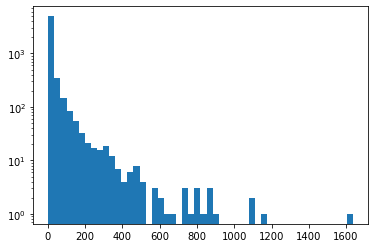

In [24]:
#Plot distribution of words

plt.hist(df_drop_rare["count"], bins=50)
plt.yscale('log')

In [26]:
#tokens = preprocess(read_all_reviews(f1))

In [34]:
#Examine words with high frequencies in the reviews

df_lots = df_drop_rare.loc[df_drop_rare["count"] > 200]
df_indexed = df_lots.reset_index().set_index("count")
dict_lots = df_lots.to_dict()
dict_lots= dict_lots['count']

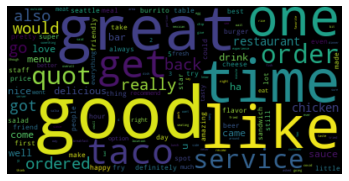

In [38]:
#Get WordCloud of high frequency words

wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=dict_lots)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Dashboard

### Putting the components together

In [55]:
df = pd.read_csv(file_path)

#Get widgets

rating_limit = widgets.FloatRangeSlider(
    value=[3.5, 5],
    min=0,
    max=5.0,
    step=0.5,
    description='Ratings',
    readout_format='.1f'
)

price_dropdown = widgets.Dropdown(
    options=["$","$$","$$$","$$$$"],
    value="$$",
    description="Price"
)

cat_list = ["category", "list"]

category_multiselect = widgets.SelectMultiple(
    options=cat_list,
    value=[cat_list[0]],
    description='Restaurant Categories'
)
    
button = widgets.Button(
    description="Update",
)

In [44]:
price_dropdown

Dropdown(description='Price', index=1, options=('$', '$$', '$$$', '$$$$'), value='$$')

In [42]:
rating_limit

FloatRangeSlider(value=(3.5, 5.0), description='Ratings', max=5.0, readout_format='.1f', step=0.5)

In [58]:
import re

df["category"].apply(lambda x: re.sub('[^A-Za-z0-9,_]+', '', x).split(","))

0             [foodtrucks, burgers, tacos]
1                    [foodtrucks, mexican]
2                      [salvadoran, tacos]
3                    [mexican, foodtrucks]
4                                [mexican]
                      ...                 
151                 [newamerican, seafood]
152             [sportsbars, tradamerican]
153    [korean, newamerican, cocktailbars]
154       [seafood, lounges, tradamerican]
155        [sandwiches, vegetarian, vegan]
Name: category, Length: 156, dtype: object

In [75]:
cat_list = []
for i in range(len(df)):
    
    categories = df["category"][i]
    cat_list.append(categories.split(","))
    
cat_list_flat = [cat for sublist in cat_list for cat in sublist]

In [74]:
cat_list

[['foodtrucks', 'burgers', 'tacos'],
 ['foodtrucks', 'mexican'],
 ['salvadoran', 'tacos'],
 ['mexican', 'foodtrucks'],
 ['mexican'],
 ['mexican', 'venues', 'breakfast_brunch'],
 ['newamerican', 'greek', 'tacos'],
 ['mexican'],
 ['tacos', 'sandwiches'],
 ['foodtrucks', 'mexican', 'catering'],
 ['mexican', 'cocktailbars'],
 ['mexican'],
 ['mexican', 'bars'],
 ['mexican', 'salad', 'bars'],
 ['coffee', 'mexican', 'breakfast_brunch'],
 ['mexican', 'steak'],
 ['grocery', 'meats', 'tacos'],
 ['mexican', 'cocktailbars'],
 ['mexican', 'foodtrucks'],
 ['mexican'],
 ['grocery', 'mexican'],
 ['mexican', 'bars', 'seafood'],
 ['foodtrucks', 'mexican'],
 ['mexican'],
 ['mexican'],
 ['mexican'],
 ['foodtrucks', 'tacos'],
 ['mexican', 'latin', 'beerbar'],
 ['hotdogs', 'mexican'],
 ['mexican', 'sportsbars'],
 ['mexican', 'breakfast_brunch', 'diners'],
 ['mexican', 'hotdogs'],
 ['venezuelan', 'empanadas', 'sandwiches'],
 ['mexican', 'bars', 'desserts'],
 ['mexican', 'breakfast_brunch'],
 ['mexican', 'bar

In [46]:
button

Button(description='Update', style=ButtonStyle())

In [48]:
rating_limit.get_interact_value()

(3.5, 5.0)

In [ ]:
def get_filter_interact(df):
    """
    Filter the given dataframe based on the widget values
    Returns mapbox viz
    """
    
    rating = rating_limit.get_interact_value()
    price = price_dropdown.get_interact_value()
    
    